#### This notebook computes the connectivity change in each analyzed epoch, by subtracting the median baseline connectivity matrix from the epoch matrix. 
#### Then, the epochs are sorted in time and K-Means clustering algorithm is applied to the connectivity data. 
#### Cluster number (k) is set to 2, to find clusters for the epileptogenic (EN) and non-epileptogenic network (NN). The smaller cluster (as the EN is smaller than NN) is then compared to the resection and scored. 
#### The scores are visualized for the sequence of epochs. Multiple connectivity measures can be considered.

In [ ]:
from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from inspect import isawaitable, iscoroutinefunction, iscoroutine

from collections.abc import Iterable as iterable

from pickle import load, dump

def isfx(field): return ismethod(field) or isfunction(field)

class GhostSet:
    """ enhanced interface (ghost) to retrieve class fields """
    def _meta(data): return {k:v for k,v in data.__dict__.items() if not isfx(v)}
    def _at_last(_, sets): pass
    def _set(object, **sets):
        ''' use to fast initialize fields | needed to avoid initialization problems at copy by value '''
        for field in sets: setattr(object, field, sets[field])
        object._at_last(sets)
GSet = GhostSet

def meta(object):
    ''' retrieves clonable object metadata (__dict__) as a copy '''
    if isinstance(object, GSet): return object._meta()
    return {}

class ClonableObjectGhost:
    """ enhanced interface (ghost) for clonable objects """
    def _by_val(_, depth=-1, _layer=0): pass
GCo = ClonableObjectGhost

class ClonableObject(GSet, GCo):
    """ base clonable object """
    def __init__(this, **data): this._set(**data)
    def __call__(_, **options): _._set(**options)
    def _by_val(_, depth=-1, _layer=0):
        copy = type(_)()
        copy._set(**_._meta())
        if depth<0 or depth>_layer:
            for field in copy.__dict__:
                if isinstance(copy.__dict__[field], ClonableObjectGhost):
                    copy.__dict__[field] = copy.__dict__[field]._by_val(depth,_layer+1)
        return copy
COb = ClonableObject

def copy_by_val(object, depth=-1, _layer=0):
    if isinstance(object, GCo): return object._by_val(depth,_layer)
    return object
copy = by_val = vof = copy_by_val

class ComparableGhost:
    """ enhanced interface (ghost) for comparing instances """
    def _compare(a, b):
        if type(a) != type(b): return False
        if a.__dict__ == b.__dict__: return True
        return False
    def __eq__(a, b): return a._compare(b)
GEq = ComparableGhost

class IterableObjectGhost(GSet):
    """ enhanced interface (ghost) for iterables: exposes __dict__,
        therefore Iterable Objects are like lua dictionaries """
    def __contains__(this, key): return key in this.__dict__
    def __iter__(this): return iter(this.__dict__)
    def items(my): return my.__dict__.items()
    def __getitem__(by, field): return by.__dict__[field]
    def __setitem__(by, field, value): by.__dict__[field] = value
    def pop(by, field): return by.__dict__.pop(field)
GIo = IterableObjectGhost

class ReprGhost:
    """ enhanced interface (ghost) for the skeleton method _repr,
        see implementation of Struct for a working example;
        Record __repr__ override uses _lines_ for max lines display """
    _lines_ = 31
    _chars_ = 13
    _msgsz_ = 62
    _ellipsis_ = ' ... '
    def _repr(my, value):
        _type = ''.join(''.join(str(type(value)).split('class ')).split("'"))
        _value = '{}'.format(value)
        if len(_value)>my._chars_:
            show = int(my._chars_/2)
            _value = _value[:show]+my._ellipsis_+_value[-show:]
        return '{} {}'.format(_type, _value)
    def _resize(this, message, at=.7):
        if len(message)>this._msgsz_:
            start = int(at*this._msgsz_)
            end = this._msgsz_-start
            return message[:start]+this._ellipsis_+message[-end:]
        return message
GRe = ReprGhost

def set_repr_to(lines): GRe._lines_ = lines

class Struct(COb, GEq, GIo, GRe):
    """ structured autoprintable object, behaves like a lua dictionary """
    def __repr__(_):
        return '\n'.join(['{}:\t{}'.format(k, _._repr(v)) for k,v in _.items()])
struct = Struct

class RecordableGhost:
    """ enhanced interface (ghost) for type recording,
        see Record for a working example """
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file: return load(file)
    def save(data, filename):
        with open(filename, 'wb') as file: dump(data, file)
        
GRec = RecordableGhost

class Record(GSet, GCo, GRec, GEq, GRe):
    """ wrapper for any object or value, auto-inspects and provides load/save type structure """
    data = None
    _check = dict(
            isfunction=isfunction, ismethod=ismethod, isgeneratorfunction=isgeneratorfunction, isgenerator=isgenerator, isroutine=isroutine,
            isabstract=isabstract, isclass=isclass, ismodule=ismodule, istraceback=istraceback, isframe=isframe, iscode=iscode, isbuiltin=isbuiltin,
            ismethoddescriptor=ismethoddescriptor, isdatadescriptor=isdatadescriptor, isgetsetdescriptor=isgetsetdescriptor, ismemberdescriptor=ismemberdescriptor,
            isawaitable=isawaitable, iscoroutinefunction=iscoroutinefunction, iscoroutine=iscoroutine
                   )
    def __init__(this, token, **meta):
        this.data = token
        this.__dict__.update({k:v(token) for k,v in this._check.items()})
        super()._set(**meta)
    @property
    def type(_): return type(_.data)
    def inherits(_, *types): return issubclass(_.type, types)
    @property
    def isbaseiterable(_): return _.inherits(tuple, list, dict, set) or _.isgenerator or _.isgeneratorfunction
    @property
    def isiterable(_): return isinstance(_.data, iterable) and _.type is not str
    def _clone_iterable(_):
        if _.inherits(dict): return _.data.copy()
        elif _.isgenerator or _.isgeneratorfunction: return (i for i in list(_.data))
        else: return type(_.data)(list(_.data)[:])
    def _meta(data): return {k:v for k,v in data.__dict__.items() if k != 'data' and not isfx(v)}
    def _by_val(_, depth=-1, layer=0):
        data = _.data
        if _.isiterable: data = _._clone_iterable()
        elif _.inherits(ClonableObjectGhost): data = by_val(data, depth, layer)
        return type(_)(data, **meta(_))
    def __enter__(self): self._instance = self; return self
    def __exit__(self, type, value, traceback): self._instance = None
    def __repr__(self):
        if not hasattr(self, '_preprint'): return Record(self.data, _preprint='', _lines=Record(Record._lines_)).__repr__()
        if self.isbaseiterable:
            pre, repr = self._preprint, ''
            for n,i in enumerate(self.data):
                if self._lines.data == 0: break
                else: self._lines.data -= 1
                index, item = str(n), i
                if self.inherits(dict): index += ' ({})'.format(str(i)); item = self.data[i]
                repr += pre+'{}: '.format(index)
                next = Record(item, _preprint=pre+'\t', _lines=self._lines)
                if next.isiterable: repr += '\n'
                repr += next.__repr__()
                repr += '\n'
            return repr
        elif self.inherits(GCo): return Record(self.data._meta(), _preprint=self._preprint, _lines=self._lines).__repr__()
        else: return self._repr(self.data)
REc = Record

class Bisect(list, COb):
    """ bisect implementation using clonable objects """
    def __init__(set, *items, key=None, reverse=False):
        if not key: key = lambda  x:x
        super().__init__(sorted(items, reverse=reverse, key=key))
    def _bisect(set, item, key, reverse, bottom, top):
        def _(check):
            if key: return key(check)
            return check
        at = int((top-bottom)/2)+bottom
        if len(set)==0: return (0,-1)
        if item==_(set[at]): return (at,0)
        bigger = item<_(set[at])
        if bigger != reverse:
            if at-bottom>0: return set._bisect(item, key, reverse, bottom, at)
            return (at,-1)
        elif top-at>1: return set._bisect(item, key, reverse, at, top)
        return (at,1)
    def search(_, item, key=None, reverse=False):
        if not key: key = lambda x:x
        return _._bisect(item, key, reverse, 0, len(_))
    def _by_val(_, depth=-1, _layer=0):
        copy = super()._by_val(depth, _layer)
        copy += _[:]
        return copy
BSx = Bisect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

main_folder = "/home/kivi/gdrive/epigame-folder/"
path_cm = main_folder + "connectivity_matrices/"
path_net = main_folder + "selected_network/"

In [ ]:
def network_validation_score(net, resection, all_nodes):
    
    not_resection = len(all_nodes)-len(resection)
    tp = len(list(set(net)&set(resection)))
    fp = len(net) - tp
    tn = not_resection - fp
    
    return (tp / len(resection)) * (tn / not_resection)

In [98]:
woi_code = {'2':"preseizure5", '3':"preseizure4", '4':"preseizure3", '5':"preseizure2", '6':"preseizure1", '7':"transition1", '8':"transition2", '9':"transition60"}
woi_code = {'6':"preseizure1", '7':"transition1"}
woi_code_inverted = {y:x for x,y in woi_code.items()}

all_nodes = ['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J2', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15']
resection = ['A3-A4', 'B2-B3', 'B5-B6', 'B6-B7', 'D3-D4', 'D4-D5', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12']

In [99]:
subject_id = "ASJ"

#### The code below gets the choice of a connection for a node, from an array of connectovity changes between that node and all other nodes, based on an evaluation function. Connectivity change is quantified as the difference between a measure and a median baseline measure.
#### However, how do we use this information to implement a game? 

In [100]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from glob import glob

In [101]:
NETS = {node:[node] for node in range(len(all_nodes))}
sequence = {}
X=None
for woi in woi_code.values():
    files_cm = glob(path_cm + f"{subject_id}-{woi}*.prep")

    for file_cm in files_cm:

        cm = REc.load(file_cm).data

        woi_ep_i = cm.i[0:int(len(cm.i)/2)] # WOI epochs' CMs

        base_eps = cm.X[int(len(cm.i)/2)::]
        median_base = np.median(base_eps, axis=0)

        # Load epochs (59 random epochs from a WOI) into a dictionary 
        sequence_randomized = {ep_i:cm.X[i]-median_base for i,ep_i in enumerate(woi_ep_i)}

        # Update the sequence dictionary with new connectivity data
        for e in sequence_randomized:
            if e in sequence: X = np.concatenate((sequence[e], sequence_randomized[e].reshape((1, sequence_randomized[e].shape[0], sequence_randomized[e].shape[1]))), axis=0)
            else: X = sequence_randomized[e].reshape((1, sequence_randomized[e].shape[0], sequence_randomized[e].shape[1]))
            sequence[e] =  X

# Sort the sequence dictionary by epochs
sequence = dict(sorted(sequence.items()))

In [102]:
import pickle
pickle.dump(sequence, open(main_folder + "sequence_epochs_cms_preseizure1-transition1.p", "wb"))

In [125]:
scores=[]

for t in sequence:

    delta = sequence[t][10:12].reshape(sequence[t].shape[-1], -1)

    # Scale the values fro different connectivity measures
    

    # for node in range(len(all_nodes)):

    #     if all_nodes[node] in resection:
    #         add_node = None
            
    #         cards = list(np.concatenate((delta[:node+1,node], delta[node,node:]), axis=0))
    #         choice = evaluation_function(cards)

    #         x,y = np.where(delta==choice)    
    #         if x[0]==node: NETS[node].append(y)
    #         elif y[0]==node: NETS[node].append(x)
    #         else: print("Error: Multiple choices.")

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(delta)

    kmeans_kwargs = {
    "init": "random",
    "n_clusters": 2,
    "n_init": 10,
    "random_state": 1,
    }

    kmeans = KMeans(kmeans_kwargs)
    kmeans.fit(delta) # should be scaled_features instead of delta
    
    l_en = 0 if list(kmeans.labels_).count(0) < list(kmeans.labels_).count(1) else 1 # Smaller cluster
    
    cluster0 = [i for i,l in enumerate(kmeans.labels_) if l==l_en]
    cluster0_nodes = [all_nodes[n_i] for n_i in cluster0]
    scores.append(network_validation_score(cluster0_nodes, resection, all_nodes))
    match = [n for n in cluster0_nodes if n in resection]
    print(len(cluster0_nodes),len(match), match, scores[-1])

31 12 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5403050108932462
26 12 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T10-T11', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5838779956427016
27 12 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T10-T11', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5751633986928104
33 12 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5228758169934641
28 13 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D3-D4', 'D4-D5'] 0.6230936819172113
33 13 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5758896151053013
29 12 ['T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T11-T12', 'D3-D4', 'D4-D5'] 0.5577342047930284
30 12 ['T1-T2', '

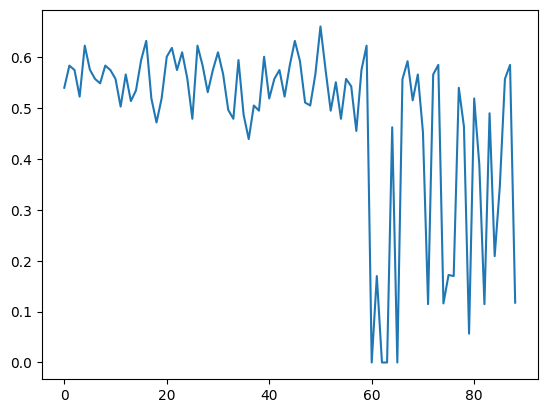

In [126]:
plt.plot(scores)